# Eye Diseases CNN

#### Load train, test and validation datasets

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=128,
    image_size=(224, 224),
    validation_split=0.2, 
    subset='training', 
    seed=123
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=128,
    image_size=(224, 224),
    validation_split=0.2, 
    subset='validation', 
    seed=123
)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


#### Standardize the data

In [13]:
validate_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(validate_batches // 2)
validation_ds = validation_ds.skip(validate_batches // 2)

normalization_layer = layers.Rescaling(1. / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = keras.Sequential([layers.RandomFlip("horizontal")])
normalized_ds = normalized_ds.map(lambda x, y: (data_augmentation(x), y))
test_ds = test_ds.map(lambda x, y: (data_augmentation(x), y))
validation_ds = validation_ds.map(lambda x, y: (data_augmentation(x), y))

### Visualize the data

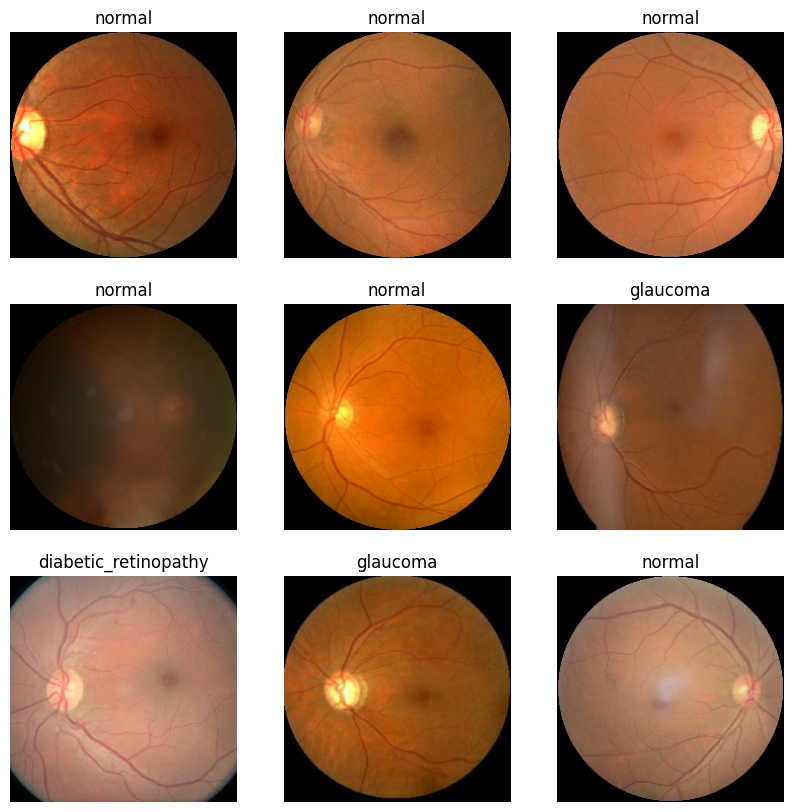

In [15]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

### Baseline Model

Create a simple baseline model of 150 hidden neurons and two layers.

In [20]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_base.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 50)                7526450   
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
Total params: 7,531,954
Trainable params: 7,531,954
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model_base.fit(
    normalized_ds,
    epochs=20,
    validation_data=validation_ds
)

Epoch 1/20
27/27 [==============================] - 21s 615ms/step - loss: 7.0139 - accuracy: 0.3865 - val_loss: 1.9442 - val_accuracy: 0.5643
Epoch 2/20
27/27 [==============================] - 18s 558ms/step - loss: 1.2317 - accuracy: 0.5907 - val_loss: 0.9337 - val_accuracy: 0.5948
Epoch 3/20
27/27 [==============================] - 19s 573ms/step - loss: 0.8506 - accuracy: 0.6369 - val_loss: 0.6994 - val_accuracy: 0.6972
Epoch 4/20
27/27 [==============================] - 18s 555ms/step - loss: 0.7348 - accuracy: 0.6648 - val_loss: 0.6786 - val_accuracy: 0.7255
Epoch 5/20
27/27 [==============================] - 19s 566ms/step - loss: 0.7135 - accuracy: 0.6725 - val_loss: 0.8194 - val_accuracy: 0.6492
Epoch 6/20
27/27 [==============================] - 18s 558ms/step - loss: 0.8775 - accuracy: 0.6405 - val_loss: 0.8632 - val_accuracy: 0.6688
Epoch 7/20
27/27 [==============================] - 18s 550ms/step - loss: 0.7281 - accuracy: 0.6903 - val_loss: 0.7960 - val_accuracy: 0.6231

In [23]:
results = model_base.evaluate(test_ds)

3/3 [==============================] - 3s 137ms/step - loss: 0.5734 - accuracy: 0.7604


In [24]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    fig.show()

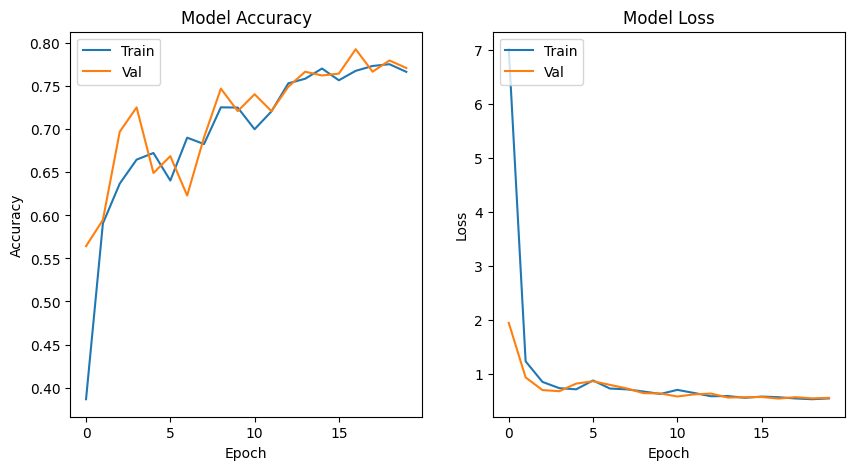

In [25]:
plot_history(history)

### Second Model

Create a model that uses dropout layers and kernel regularizers to reduce the gap between training and validation accuracy.

In [26]:
model_optimize = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_optimize.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 19,301,764
Trainable params: 19,301,764


In [27]:
model_optimize.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
history_optimizer = model_optimize.fit(
    normalized_ds,
    epochs=20,
    validation_data=validation_ds
)

Epoch 1/20
27/27 [==============================] - 21s 638ms/step - loss: 10.1329 - accuracy: 0.3435 - val_loss: 1.3059 - val_accuracy: 0.3224
Epoch 2/20
27/27 [==============================] - 21s 644ms/step - loss: 1.2398 - accuracy: 0.3939 - val_loss: 1.0729 - val_accuracy: 0.5011
Epoch 3/20
27/27 [==============================] - 21s 645ms/step - loss: 1.1999 - accuracy: 0.4392 - val_loss: 1.0519 - val_accuracy: 0.4466
Epoch 4/20
27/27 [==============================] - 21s 656ms/step - loss: 1.1138 - accuracy: 0.4508 - val_loss: 1.0273 - val_accuracy: 0.4641
Epoch 5/20
27/27 [==============================] - 20s 630ms/step - loss: 1.0773 - accuracy: 0.4615 - val_loss: 0.9606 - val_accuracy: 0.5316
Epoch 6/20
27/27 [==============================] - 21s 633ms/step - loss: 1.0496 - accuracy: 0.4627 - val_loss: 1.0014 - val_accuracy: 0.4641
Epoch 7/20
27/27 [==============================] - 21s 646ms/step - loss: 1.0409 - accuracy: 0.4588 - val_loss: 0.9701 - val_accuracy: 0.459

In [29]:
results = model_optimize.evaluate(test_ds)

3/3 [==============================] - 4s 157ms/step - loss: 0.9357 - accuracy: 0.4896


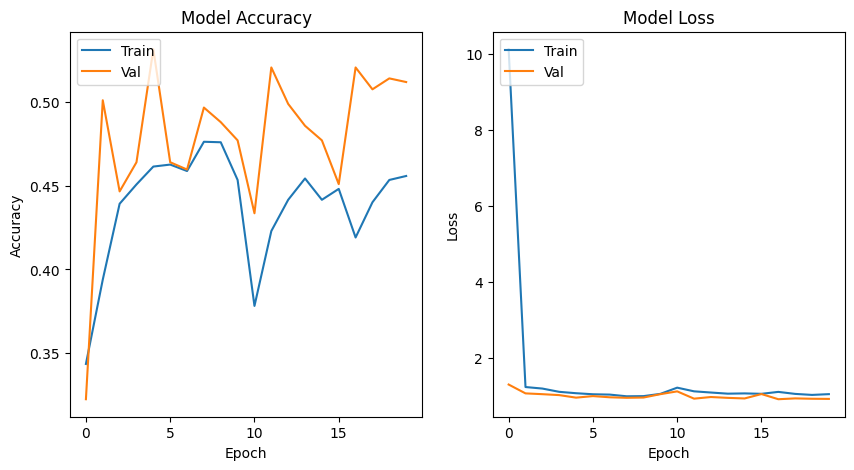

In [30]:
plot_history(history_optimizer)

### Third Model

Create a Convolutional Neural Network (CNN) to improve the accuracy for our overall image classification model. 

In [31]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(50, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(60, (3, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(70, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 40)      1120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 40)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 50)      18050     
                                                                 
 dropout_2 (Dropout)         (None, 109, 109, 50)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 60)      27060     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 60)       0         
 2D)                                                  

In [32]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
cnn_history = cnn_model.fit(
    normalized_ds,
    epochs=20,
    validation_data=validation_ds
)

Epoch 1/20
27/27 [==============================] - 260s 9s/step - loss: 1.4352 - accuracy: 0.4001 - val_loss: 1.0666 - val_accuracy: 0.5447
Epoch 2/20
27/27 [==============================] - 261s 10s/step - loss: 0.9293 - accuracy: 0.5830 - val_loss: 0.8521 - val_accuracy: 0.6122
Epoch 3/20
27/27 [==============================] - 254s 9s/step - loss: 0.8111 - accuracy: 0.6506 - val_loss: 0.7664 - val_accuracy: 0.6950
Epoch 4/20
27/27 [==============================] - 249s 9s/step - loss: 0.7128 - accuracy: 0.7072 - val_loss: 0.7353 - val_accuracy: 0.6601
Epoch 5/20
27/27 [==============================] - 261s 10s/step - loss: 0.6341 - accuracy: 0.7424 - val_loss: 0.6255 - val_accuracy: 0.7407
Epoch 6/20
27/27 [==============================] - 257s 9s/step - loss: 0.6069 - accuracy: 0.7599 - val_loss: 0.6029 - val_accuracy: 0.7756
Epoch 7/20
27/27 [==============================] - 483s 18s/step - loss: 0.5915 - accuracy: 0.7694 - val_loss: 0.6162 - val_accuracy: 0.7669
Epoch 8/20

In [34]:
results = cnn_model.evaluate(test_ds)

3/3 [==============================] - 14s 3s/step - loss: 0.4679 - accuracy: 0.8333


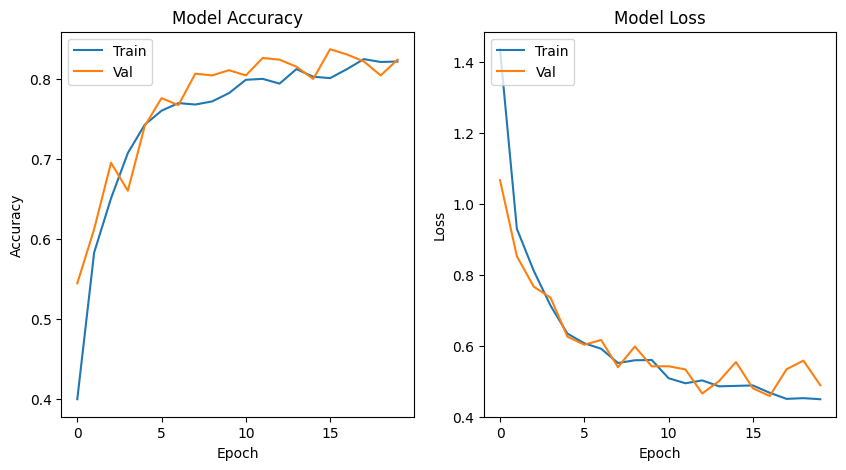

In [35]:
plot_history(cnn_history)

### Transfer Learning

For our final model, we integrate a pre-trained model (Xception) to help improve accuracy.

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=32,
    image_size=(200, 200),
    validation_split=0.2, 
    subset='training', 
    seed=123
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=32,
    image_size=(200, 200),
    validation_split=0.2, 
    subset='validation', 
    seed=123
)

validate_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(validate_batches // 2)
validation_ds = validation_ds.skip(validate_batches // 2)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [42]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                           

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
106/106 [==============================] - 355s 3s/step - loss: 0.8279 - accuracy: 0.6615 - val_loss: 0.5554 - val_accuracy: 0.7963
Epoch 2/20
106/106 [==============================] - 351s 3s/step - loss: 0.5706 - accuracy: 0.7919 - val_loss: 0.4991 - val_accuracy: 0.8244
Epoch 3/20
106/106 [==============================] - 354s 3s/step - loss: 0.5093 - accuracy: 0.8082 - val_loss: 0.4676 - val_accuracy: 0.8267
Epoch 4/20
106/106 [==============================] - 352s 3s/step - loss: 0.4706 - accuracy: 0.8204 - val_loss: 0.4358 - val_accuracy: 0.8361
Epoch 5/20
106/106 [==============================] - 352s 3s/step - loss: 0.4390 - accuracy: 0.8417 - val_loss: 0.4424 - val_accuracy: 0.8337
Epoch 6/20
106/106 [==============================] - 350s 3s/step - loss: 0.4240 - accuracy: 0.8441 - val_loss: 0.4027 - val_accuracy: 0.8548
Epoch 7/20
106/106 [==============================] - 352s 3s/step - loss: 0.4109 - accuracy: 0.8429 - val_loss: 0.3840 - val_accuracy: 0.8642

Fine-tune the model by unfreezing the base model and training with a low learning rate.

In [44]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy', 
    metrics=['accuracy'],
)

history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                           

In [45]:
results = model.evaluate(test_ds)

13/13 [==============================] - 29s 2s/step - loss: 0.2553 - accuracy: 0.9399


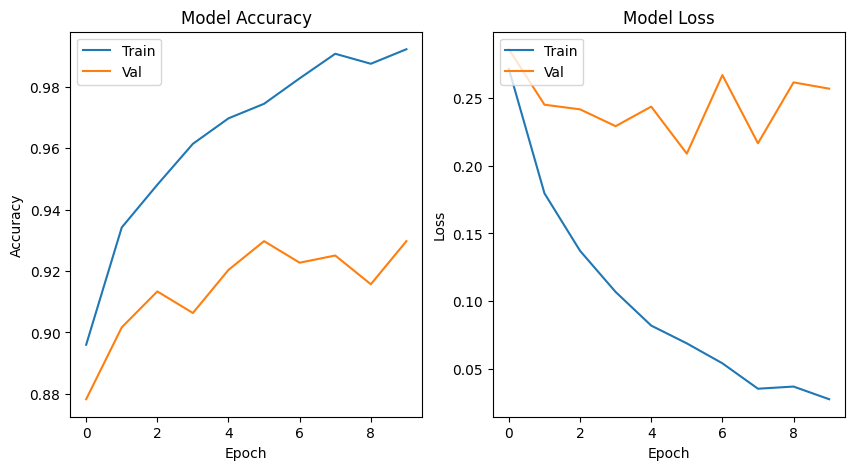

In [46]:
plot_history(history)

#### Classification Report

In [125]:
from itertools import chain

cached_ds = test_ds.cache()
y_true = list(map(lambda x: x[1], cached_ds))
y_true = list(chain(*list(map(lambda x: x.numpy(), y_true))))
y_true = np.argmax(y_true, axis=1)

In [126]:
y_pred = model.predict(cached_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

In [127]:
from sklearn.metrics import classification_report

num_classes = 4
y_true_bin = keras.utils.to_categorical(y_true, num_classes)
y_pred_bin = keras.utils.to_categorical(y_pred_labels, num_classes)

report = classification_report(y_true_bin, y_pred_bin)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        96
           1       0.99      1.00      1.00       103
           2       0.86      0.89      0.87       107
           3       0.89      0.85      0.87       110

   micro avg       0.92      0.92      0.92       416
   macro avg       0.92      0.92      0.92       416
weighted avg       0.92      0.92      0.92       416
 samples avg       0.92      0.92      0.92       416



#### Confusion Matrix

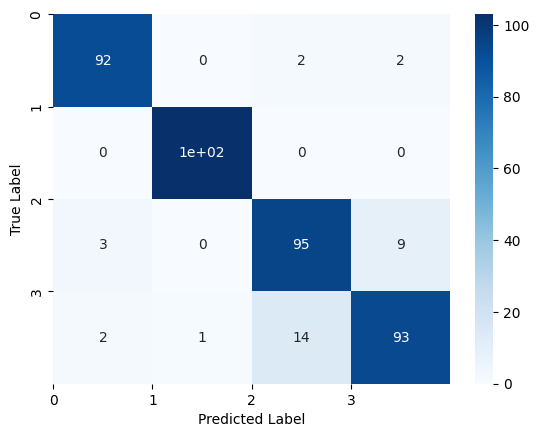

In [128]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, cmap='Blues')
classes = np.unique(y_true)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()